In [4]:
#@title Imports and utility code


import numpy as onp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True); jax.config.update("jax_debug_nans", False)

from jax import random
from jax import jit, lax, grad, vmap
import jax.scipy as jsp

from jax_md import space, energy, smap, minimize, util, elasticity, quantity

f32 = jnp.float32
f64 = jnp.float64

from functools import partial

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])


def run_minimization_while(energy_fn, R_init, shift, max_grad_thresh = 1e-12, max_num_steps=1000000, **kwargs):
  init,apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def cond_fn(val):
    state, i = val
    return jnp.logical_and(get_maxgrad(state) > max_grad_thresh, i<max_num_steps)

  @jit
  def body_fn(val):
    state, i = val
    return apply(state), i+1

  state = init(R_init)
  state, num_iterations = lax.while_loop(cond_fn, body_fn, (state, 0))

  return state.position, get_maxgrad(state), num_iterations

def run_minimization_while_neighbor_list(energy_fn, neighbor_fn, R_init, shift,
                                         max_grad_thresh = 1e-12, max_num_steps = 1000000,
                                         step_inc = 1000, verbose = False, **kwargs):
  nbrs = neighbor_fn.allocate(R_init)

  init,apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def get_maxgrad(state):
    return jnp.amax(jnp.abs(state.force))

  @jit
  def body_fn(state_nbrs, t):
    state, nbrs = state_nbrs
    nbrs = neighbor_fn.update(state.position, nbrs)
    state = apply(state, neighbor=nbrs)
    return (state, nbrs), 0

  state = init(R_init, neighbor=nbrs)

  step = 0
  while step < max_num_steps:
    if verbose:
      print('minimization step {}'.format(step))
    rtn_state, _ = lax.scan(body_fn, (state, nbrs), step + jnp.arange(step_inc))
    new_state, nbrs = rtn_state
    # If the neighbor list overflowed, rebuild it and repeat part of
    # the simulation.
    if nbrs.did_buffer_overflow:
      print('Buffer overflow.')
      nbrs = neighbor_fn.allocate(state.position)
    else:
      state = new_state
      step += step_inc
      if get_maxgrad(state) <= max_grad_thresh:
        break

  if verbose:
    print('successfully finished {} steps.'.format(step*step_inc))

  return state.position, get_maxgrad(state), nbrs, step

def run_minimization_scan(energy_fn, R_init, shift, num_steps=5000, **kwargs):
  init,apply=minimize.fire_descent(jit(energy_fn), shift, **kwargs)
  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  state = init(R_init)
  state, _ = lax.scan(scan_fn,state,jnp.arange(num_steps))

  return state.position, jnp.amax(jnp.abs(state.force))

key = random.PRNGKey(0)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


#Linear elasticity in athermal systems

## The elastic modulus tensor

An global affine deformation is given to lowest order by a symmetric strain tensor $\epsilon$, which transforms any vector $r$ according to
\begin{equation}
r \rightarrow (1 + \epsilon) \cdot r.
\end{equation}
Note that in $d$ dimensions, the strain tensor has $d(d + 1)/2$ independent elements. Now, when a mechanically stable system (i.e. a system at a local energy minimum where there is zero net force on every particle) is subject to an affine deformation, it usually does not remain in mechanical equilibrium. Therefore, there is a secondary, nonaffine response that returns the system to mechanical equilibrium, though usually at a different energy than the undeformed state.

The change of energy can be written to quadratic order as
\begin{equation}
\frac{ \Delta U}{V^0} = \sigma^0_{ij}\epsilon_{ji} + \frac 12 C_{ijkl} \epsilon_{ij} \epsilon_{kl} + O\left( \epsilon^3 \right)
\end{equation}
where $C_{ijkl}$ is the $d × d × d × d$ elastic modulus tensor, $\sigma^0$ is the $d × d$ symmetric stress tensor describing residual stresses in the initial state, and $V^0$ is the volume of the initial state. The symmetries of $\epsilon_{ij}$ imply the following:
\begin{equation}
C_{ijkl} = C_{jikl} = C_{ijlk} = C_{klij}
\end{equation}
When no further symmetries are assumed, the number of independent elastic constants becomes $\frac 18 d(d + 1)(d^2 + d + 2)$, which is 6 in two dimensions and 21 in three dimensions.


##Linear response to an external force

Consider a set of $N$ particles in $d$ dimensions with positions $R_0$. Using $u \equiv R - R_0$ and assuming fixed boundary conditions, we can expand the energy about $R_0$:
\begin{equation}
U = U^0 - F^0 u + \frac 12 u H^0 u + O(u^3),
\end{equation}
where $U^0$ is the energy at $R_0$, $F^0$ is the force, $F^0_\mu \equiv \left. \frac {\partial U}{\partial u_\mu} \right |_{u=0}$, and $H^0$ is the Hessian, $H^0 \equiv \left. \frac{ \partial^2 U}{\partial u_\mu \partial u_\nu}\right|_{u=0}$.
Note that here we are expanding in terms of the particle positions, where as above we were expanding in the global strain degrees of freedom.
If we assume that $R_0$ corresponds to a local energy minimum, then $F^0=0$. Dropping higher order terms, we have a system of coupled harmonic oscillators given by
\begin{equation}
\Delta U \equiv U - U^0 = \frac 12 u H^0 u.
\end{equation}
This is independent of the form or details of $U$.

Hooke's law for this system gives the net force $f$ as a result of displacing the particles by $u$:
\begin{equation}
f = -H^0 u.
\end{equation}
Thus, if an *external* force $f_\mathrm{ext}$ is applied, the particles will respond so that the total force is zero, i.e. $f = -f_\mathrm{ext}$. This response is obtained by solving for $u$:
\begin{equation}
u = (H^0)^{-1} f_\mathrm{ext}.
\end{equation}


## Response to an affine strain

Now consider a strain tensor $\epsilon = \tilde \epsilon \gamma$, where $\gamma$ is a scalar and will be used to explicitly take the limit of small strain for fixed $\tilde \epsilon$. Importantly, the strain tensor represents a deformation of the underlying space that the particles live in and thus is a degree of freedom that is independent of the $Nd$ particle degrees of freedom. Therefore, knowing the particle positions $R$ is not sufficient to describe the energy, we also need to know $\gamma$ to specify the correct boundary conditions:
\begin{equation}
U = U(R, \gamma).
\end{equation}

We now have a system with $Nd+1$ variables $\{R, \gamma\}$ that, like before, form a set of coupled harmonic oscillators. We can describe this using the so-called "generalized Hessian" matrix of second derivatives of the energy with respect to both $R$ and $\gamma$. Specifically, Hooke's law reads
\begin{equation}
  \left( \begin{array}{ ccccc|c}
	&&&&&\\
	&&H^0 &&& -\Xi \\
	&&&&& \\ \hline
	&&-\Xi^T &&&\frac{\partial ^2U}{\partial \gamma^2}
	\end{array}\right)
  \left( \begin{array}{ c}
	\\
	u \\
	\\ \hline
	\gamma
	\end{array}\right)
  =
  \left( \begin{array}{ c}
	\\
	0 \\
	\\ \hline
	\tilde \sigma
	\end{array}\right),
\end{equation}

where $u = R - R_0$ is the displacement of every particle, $\Xi = -\frac{ \partial^2 U}{\partial R \partial \gamma}$, and $\tilde \sigma$ is the induced stress caused by the deformation. (If there is prestress in the system, i.e. $\sigma^0 = \frac{\partial U}{\partial \gamma} \neq 0$, the total stress is $\sigma = \sigma^0 + \tilde \sigma$.) In this equation, $\gamma$ is held fixed and the zero in the top of the right-hand-side imposes force balance after the deformation and resulting non-affine displacement of every particle. The non-affine displacement itself, $u$, and the induced stress $\sigma$, are both unknown but can be solved for. First, the non-affine response is
\begin{equation}
u = (H^0)^{-1} \Xi \; \gamma,
\end{equation}
where we note that in the limit of small $\gamma$, the force induced on every particle due to the affine deformation is $\Xi \; \gamma$. Second, the induced stress is
\begin{equation}
\tilde \sigma = \frac{\partial ^2U}{\partial \gamma^2} \gamma - \Xi^T u = \left(\frac{\partial ^2U}{\partial \gamma^2} - \Xi^T (H^0)^{-1} \Xi  \right) \gamma.
\end{equation}

Similarly, the change in energy is
\begin{equation}
\frac{\Delta U}{V^0} = \sigma^0 \gamma + \frac 1{2V^0} \left(\frac{\partial ^2U}{\partial \gamma^2} - \Xi^T (H^0)^{-1} \Xi  \right) \gamma^2,
\end{equation}
where $\sigma^0$ is the prestress in the system per unit volume. Comparing this to the above definition of the the elastic modulus tensor, we see that the elastic constant associated with the deformation $\tilde \epsilon$ is
\begin{equation}
C(\tilde \epsilon) = \frac 1{V^0} \left( \frac{\partial^2 U}{\partial \gamma^2} - \Xi^T (H^0)^{-1} \Xi \right).
\end{equation}

$C(\tilde \epsilon)$ is related to $C_{ijkl}$ by summing $C(\tilde \epsilon) = C_{ijkl}\tilde \epsilon_{ij} \tilde \epsilon_{kl}$. So, if $\tilde \epsilon_{ij} = \delta_{0i}\delta_{0j}$, then $C_{0000} = C(\tilde \epsilon)$.

The internal code in `jax_md.elasticity` repeats this calculation for different $\tilde \epsilon$ to back out the different independent elastic constants.

#First example


As a first example, let's consider a 3d system of 128 soft spheres. The elastic modulus tensor is only defined for systems that are at a local energy minimum, so we start by minimizing the energy.

In [5]:
N = 128
dimension = 3

box_size = quantity.box_size_at_number_density(N, 1.4, dimension)
displacement, shift = space.periodic(box_size)

energy_fn = energy.soft_sphere_pair(displacement)

key, split = random.split(key)
R_init = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64)

R, max_grad, niters = run_minimization_while(energy_fn, R_init, shift)
print('Minimized the energy in {} minimization steps and reached a final \
maximum gradient of {}'.format(niters, max_grad))

Minimized the energy in 1748 minimization steps and reached a final maximum gradient of 9.711363657682881e-13


We can now calculate the elastic modulus tensor

In [6]:
emt_fn = jit(elasticity.athermal_moduli(energy_fn, check_convergence=True))
C, converged = emt_fn(R,box_size)
print(converged)

True


The elastic modulus tensor gives a quantitative prediction for how the energy should change if we deform the system according to a strain tensor
\begin{equation}
\frac{ \Delta U}{V^0} = \sigma^0\epsilon + \frac 12 \epsilon C  \epsilon + O\left(\epsilon^3\right)
\end{equation}
To test this, we define $\epsilon = \tilde \epsilon \gamma$ for a randomly chosen strain tensor $\tilde \epsilon$ and for $\gamma << 1$. Ignoring terms of order $\gamma^3$ and higher, we have
\begin{equation}
\frac{ \Delta U}{V^0} - \sigma^0\epsilon = \left[\frac 12 \tilde \epsilon C  \tilde \epsilon \right] \gamma^2
\end{equation}
Thus, we can test our calculation of $C$ by plotting $\frac{ \Delta U}{V^0} - \sigma^0\epsilon$ as a function of $\gamma$ for our randomly chosen $\tilde \epsilon$ and comparing it to the line $\left[\frac 12 \tilde \epsilon C  \tilde \epsilon \right] \gamma^2$.

First, generate a random $\tilde \epsilon$ and calculate $U$ for different $\gamma$.

In [5]:
key, split = random.split(key)
#Pick a random (symmetric) strain tensor
strain_tensor = random.uniform(split, (dimension,dimension), minval=-1, maxval=1, dtype=f64)
strain_tensor = (strain_tensor + strain_tensor.T) / 2.0

#Define a function to calculate the energy at a given strain
def get_energy_at_strain(gamma, strain_tensor, R_init, box):
  R_init = space.transform(space.inverse(box),R_init)
  new_box = jnp.matmul(jnp.eye(strain_tensor.shape[0]) + gamma * strain_tensor, box)
  displacement, shift = space.periodic_general(new_box, fractional_coordinates=True)
  energy_fn = energy.soft_sphere_pair(displacement, sigma=1.0)
  R_final, _, _ = run_minimization_while(energy_fn, R_init, shift)
  return energy_fn(R_final)

gammas = jnp.logspace(-7,-4,50)
Us = vmap(get_energy_at_strain, in_axes=(0,None,None,None))(gammas, strain_tensor, R, box_size * jnp.eye(dimension))

Plot $\frac{ \Delta U}{V^0} - \sigma^0\epsilon$ and $\left[\frac 12 \tilde \epsilon C  \tilde \epsilon \right] \gamma^2$ as functinos of $\gamma$. While there may be disagreements for very small $\gamma$ due to numerical precision or at large $\gamma$ due to higher-order terms becoming relevant, there should be a region of quantitative agreement.

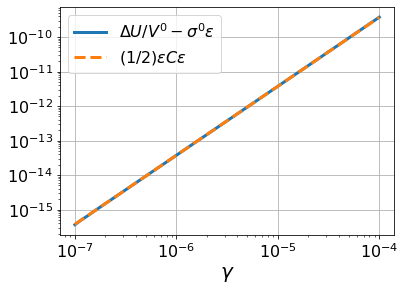

In [6]:
U_0 = energy_fn(R)
stress_0 = -quantity.stress(energy_fn, R, box_size)
V_0 = quantity.volume(dimension, box_size)

#Plot \Delta E/V - sigma*epsilon
y1 = (Us - U_0)/V_0 - gammas * jnp.einsum('ij,ji->',stress_0,strain_tensor)
plt.plot(jnp.abs(gammas), y1, lw=3, label=r'$\Delta U/V^0 - \sigma^0 \epsilon$')

#Plot 0.5 * epsilon*C*epsilon
y2 = 0.5 * jnp.einsum('ij,ijkl,kl->',strain_tensor, C, strain_tensor) * gammas**2
plt.plot(jnp.abs(gammas), y2, ls='--', lw=3, label=r'$(1/2) \epsilon C \epsilon$')

plt.xscale('log')
plt.yscale('log')
plt.legend()
format_plot('$\gamma$','')
finalize_plot()

To test the accuracy of this agreement, we first define:
\begin{equation}
T(\gamma) = \frac{ \Delta U}{V^0} - \sigma^0\epsilon - \frac 12 \epsilon C  \epsilon \sim O\left(\gamma^3\right)
\end{equation}
which should be proportional to $\gamma^3$ for small $\gamma$ (note that this expected scaling should break down when the y-axis approaches machine precision). This is a prediction of scaling only, so we plot a line proportional to $\gamma^3$ to compare the slopes.

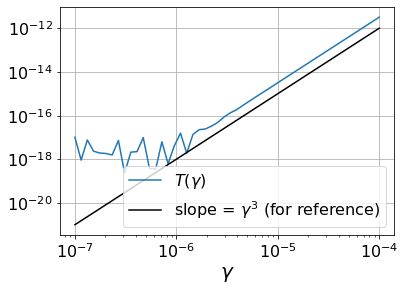

In [7]:
#Plot the difference, which should scales as gamma**3
plt.plot(jnp.abs(gammas), jnp.abs(y1-y2), label=r'$T(\gamma)$')
#Plot gamma**3 for reference
plt.plot(jnp.abs(gammas), jnp.abs(gammas**3), 'black', label=r'slope = $\gamma^3$ (for reference)')

plt.xscale('log')
plt.yscale('log')
plt.legend()
format_plot('$\gamma$','')
finalize_plot()

Save `C` for later testing.

In [ ]:
C_3d = C

#Example with neighbor lists

As a second example, consider a much larger systems that is implemented using neighbor lists.

In [8]:
N = 5000
dimension = 2

box_size = quantity.box_size_at_number_density(N, 1.3, dimension)
box = box_size * jnp.eye(dimension)
displacement, shift = space.periodic_general(box, fractional_coordinates=True)

sigma = jnp.array([[1.0, 1.2], [1.2, 1.4]])
N_2 = int(N / 2)
species = jnp.where(jnp.arange(N) < N_2, 0, 1)

neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement, box_size, species=species, sigma=sigma, dr_threshold = 0.1,
    fractional_coordinates = True)

key, split = random.split(key)
R_init = random.uniform(split, (N,dimension), minval=0.0, maxval=1.0, dtype=f64)

R, max_grad, nbrs, niters = run_minimization_while_neighbor_list(energy_fn, neighbor_fn, R_init, shift)
print('Minimized the energy in {} minimization steps and reached a final \
maximum gradient of {}'.format(niters, max_grad))

/home/abhishek/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Minimized the energy in 4000 minimization steps and reached a final maximum gradient of 5.410949466266857e-13


We have to pass the neighbor list to `emt_fn`.

In [9]:
emt_fn = jit(elasticity.athermal_moduli(energy_fn, check_convergence=True))
C, converged = emt_fn(R,box,neighbor=nbrs)
print(converged)

True


We can time the calculation of the compiled function.

In [ ]:
%timeit emt_fn(R,box,neighbor=nbrs)

Repeat the same tests as above. NOTE: this may take a few minutes.

In [ ]:
key, split = random.split(key)
#Pick a random (symmetric) strain tensor
strain_tensor = random.uniform(split, (dimension,dimension), minval=-1, maxval=1, dtype=f64)
strain_tensor = (strain_tensor + strain_tensor.T) / 2.0

def get_energy_at_strain(gamma, strain_tensor, R_init, box):
  new_box = jnp.matmul(jnp.eye(strain_tensor.shape[0]) + gamma * strain_tensor, box)
  displacement, shift = space.periodic_general(new_box, fractional_coordinates=True)

  neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement, box_size, species=species, sigma=sigma, dr_threshold = 0.1,
    fractional_coordinates = True, capacity_multiplier = 1.5)

  R_final, _, nbrs, _ = run_minimization_while_neighbor_list(energy_fn, neighbor_fn, R_init, shift)
  return energy_fn(R_final, neighbor=nbrs)

gammas = jnp.logspace(-7,-3,20)
Us = jnp.array([ get_energy_at_strain(gamma, strain_tensor, R, box) for gamma in gammas])

In [ ]:
U_0 = energy_fn(R, neighbor=nbrs)
stress_0 = -quantity.stress(energy_fn, R, box, neighbor=nbrs)
V_0 = quantity.volume(dimension, box)

#Plot \Delta E/V - sigma*epsilon
y1 = (Us - U_0)/V_0 - gammas * jnp.einsum('ij,ji->',stress_0,strain_tensor)
plt.plot(jnp.abs(gammas), y1, lw=3, label=r'$\Delta U/V^0 - \sigma^0 \epsilon$')

#Plot 0.5 * epsilon*C*epsilon
y2 = 0.5 * jnp.einsum('ij,ijkl,kl->',strain_tensor, C, strain_tensor) * gammas**2
plt.plot(jnp.abs(gammas), y2, ls='--', lw=3, label=r'$(1/2) \epsilon C \epsilon$')

plt.xscale('log')
plt.yscale('log')
plt.legend()
format_plot('$\gamma$','')
finalize_plot()

In [ ]:
#Plot the difference, which should scales as gamma**3
plt.plot(jnp.abs(gammas), jnp.abs(y1-y2), label=r'$T(\gamma)$')
#Plot gamma**3 for reference
plt.plot(jnp.abs(gammas), jnp.abs(gammas**3), 'black', label=r'slope = $\gamma^3$ (for reference)')

plt.xscale('log')
plt.yscale('log')
plt.legend()
format_plot('$\gamma$','')
finalize_plot()

Save `C` for later testing.

In [ ]:
C_2d = C

#Mandel notation

Mandel notation is a way to represent symmetric second-rank tensors and fourth-rank tensors with so-called "minor symmetries", i.e. $T_{ijkl} = T_{ijlk} = T_{jilk}$. The idea is to map pairs of indices so that $(i,i) \rightarrow i$ and $(i,j) \rightarrow K - i - j$ for $i\neq j$, where $K = d(d+1)/2$ is the number of independent pairs $(i,j)$ for tensors with $d$ elements along each axis. Thus, second-rank tensors become first-rank tensors, and fourth-rank tensors become second-rank tensors, according to:

\begin{align}
M_{m(i,j)} &= T_{ij} w(i,j) \\
M_{m(i,j),m(k,l)} &= T_{ijkl} w(i,j) w(k,l).
\end{align}

Here, $m(i,j)$ is the mapping function described above, and w(i,j) is a weight that preserves summation rules and is given by
\begin{align}
w(i,j) = \delta_{ij} + \sqrt{2} (\delta_{ij}-1).
\end{align}

We can convert strain tensors, stress tensors, and elastic modulus tensors to and from Mandel notation using the functions `elasticity.tensor_to_mandel` and `elasticity.mandel_to_tensor`.

First, lets copy one of the previously calculated elastic modulus tensors and define a random strain tensor.

In [ ]:
#This can be 2 or 3 depending on which of the above solutions has been calculated
dimension = 3
if dimension == 2:
  C = C_2d
else:
  C = C_3d
key, split = random.split(key)
e = random.uniform(key, (dimension,dimension), minval=-1, maxval=1, dtype=f64)
e = (e + e.T)/2.

Convert `e` and `C` to Mental notation

In [ ]:
e_m = jit(elasticity.tensor_to_mandel)(e)
C_m = jit(elasticity.tensor_to_mandel)(C)
print(e_m)
print(C_m)

Using "bar" notation to represent Mandel vectors and matrices, we have
\begin{equation}
\frac{ \Delta U}{V^0} = \bar \sigma_i^0 \bar\epsilon_i + \frac 12 \bar \epsilon_i \bar C_{ij} \bar\epsilon_j + O\left(\bar \epsilon^3\right)
\end{equation}
We can explicity test that the sums are equivalent to the sums involving the original tensors

In [ ]:
sum_m = jnp.einsum('i,ij,j->',e_m, C_m, e_m)
sum_t = jnp.einsum('ij,ijkl,kl->',e, C, e)
print('Relative error is {}, which should be very close to 0'.format((sum_t-sum_m)/sum_t))

Finally, we can convert back to the full tensors and check that they are unchanged.

In [ ]:
C_new = jit(elasticity.mandel_to_tensor)(C_m)
print('Max error in C is {}, which should be very close to 0.'.format(jnp.max(jnp.abs(C-C_new))))

e_new = jit(elasticity.mandel_to_tensor)(e_m)
print('Max error in e is {}, which should be very close to 0.'.format(jnp.max(jnp.abs(e-e_new))))

# Isotropic elastic constants


The calculation of the elastic modulus tensor does not make any assumptions about the underlying symmetries in the material. However, for isotropic systems, only two constants are needed to completely describe the elastic behavior. These are often taken to be the bulk modulus, $B$, and the shear modulus, $G$, or the Young's modulus, $E$, and the Poisson's ratio, $\nu$. The function `elasticity.extract_isotropic_moduli` extracts these values, as well as the longitudinal modulus, $M$, from an elastic modulus tensor.

Importantly, since there is not guarantee that `C` is calculated from a truely isotropic systems, these are "orientation-averaged" values. For example, there are many directions in which you can shear a system, and the shear modulus that is returned represents and average over all these orientations. This can be an effective way to average over small fluctuations in an "almost isotropic" system, but the values lose their typical meaning when the systems is highly anisotropic.

In [ ]:
elasticity.extract_isotropic_moduli(C)

# Gradients

The calculation of the elastic modulus tensor is fully differentiable:

In [10]:
def setup(N,dimension,key):
  box_size = quantity.box_size_at_number_density(N, 1.4, dimension)
  box = box_size * jnp.eye(dimension)
  displacement, shift = space.periodic_general(box, fractional_coordinates=True)
  R_init = random.uniform(key, (N,dimension), minval=0.0, maxval=1.0, dtype=f64)

  def run(sigma):
    energy_fn = energy.soft_sphere_pair(displacement, sigma=sigma)
    R, max_grad = run_minimization_scan(energy_fn, R_init, shift, num_steps=1000)
    emt_fn = jit(elasticity.athermal_moduli(energy_fn))
    C = emt_fn(R,box)
    return elasticity.extract_isotropic_moduli(C)['G']
  return run

key, split = random.split(key)
N = 50
dimension = 2
run = setup(N, dimension, split)

In [10]:
def setup_R(N,dimension,key):
  box_size = quantity.box_size_at_number_density(N, 1.4, dimension)
  box = box_size * jnp.eye(dimension)
  displacement, shift = space.periodic(box_size)#, fractional_coordinates=True)
  

  def run(R_init):
    sigma = jnp.linspace(1.0,1.4,N)
    energy_fn = energy.soft_sphere_pair(displacement, sigma=sigma)
    R, max_grad = run_minimization_scan(energy_fn, R_init, shift, num_steps=1000)
    emt_fn = jit(elasticity.athermal_moduli(energy_fn))
    C = emt_fn(R,box)
    return elasticity.extract_isotropic_moduli(C)['nu']
  return run

key, split = random.split(key)
N = 50
dimension = 2

R_init = random.uniform(key, (N,dimension), minval=0.0, maxval=1.0, dtype=f64)
run = setup_R(N, dimension, split)

In [11]:

print(run(R_init))
print(grad(run)(R_init))

0.42931097751373754
[[-1.42222669e-09 -1.16029501e-09]
 [-5.77921503e-11  2.03273273e-10]
 [ 3.51053842e-10  1.09412013e-09]
 [ 1.67137368e-11 -1.03645653e-10]
 [-1.25401847e-10 -2.68830241e-10]
 [-1.70649793e-10 -6.19809440e-10]
 [ 5.18962978e-10  1.31053254e-10]
 [ 2.49289118e-09  1.03231252e-09]
 [ 1.74884932e-11 -3.17426200e-11]
 [-7.23308077e-10 -1.47717551e-10]
 [ 1.42004598e-10 -5.78242020e-10]
 [ 3.22936522e-10  1.06435804e-09]
 [ 6.37327907e-11  1.15044134e-10]
 [-1.17810441e-09 -4.43354266e-11]
 [-7.94305368e-10 -1.58995888e-09]
 [-2.32732312e-10  1.20859672e-09]
 [ 4.81097450e-10 -1.11725781e-10]
 [ 8.47005062e-10 -1.48128070e-09]
 [-6.62567139e-11 -3.63787969e-10]
 [ 2.38057575e-10 -8.45261318e-11]
 [ 1.74586415e-11 -7.92282551e-11]
 [ 1.07790194e-10  2.27832397e-10]
 [-1.98921616e-10  8.05052200e-10]
 [ 5.64841077e-11  4.17814983e-11]
 [ 5.26318996e-10  4.67177137e-10]
 [ 3.98357750e-10  7.60102113e-10]
 [-4.27968139e-11 -5.47608513e-11]
 [ 1.14441712e-10  1.10055881e-10]
